# Módulo Deep Learning: Solución a la práctica

En este notebook se presenta una posible solución completa de la práctica, incluyendo algunas discusiones adicionales relativas a los resultados, como ejemplo de cómo abordar desde primeros principios un problema real mediante técnicas de Deep Learning. El notebook se distribuye de la siguiente manera:

1. Carga de datos
2. Preprocesado de los datos
3. Hito 1: Modelos 1D
4. Hito 2: Modelos 2D
5. Hito 3: Late-fusion
6. Hito 4: Early-fusion
7. Resultados
8. Discusión

In [1]:
# permitimos el acceso a nuestra carpeta de GDrive para simplificar el proceso,
# si bien podríamos subir manualmente los datos a mano.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Carga de los datos

En primer lugar debemos cargar las librerías necesarias para interactuar con datos que tengamos en local, o en Google Drive.

In [82]:
import pandas
from pathlib import Path

DATA_DIR = "/content/drive/MyDrive/HAM10000"
METADATA = "HAM10000_metadata.csv"
IMAGES = "hnmist_28_28_RGB.csv"

def load_dataset(N: int = None):
    """ Load the dataset up to `N` samples. If `N` is None, load the entire dataset. """
    metadata = pandas.read_csv(Path(DATA_DIR) / METADATA)
    images = pandas.read_csv(Path(DATA_DIR) / IMAGES)
    if N is not None:
        metadata = metadata[:N]
        images = images[:N]
    return metadata, images

tab_data, im_data = load_dataset()

Visualizamos las primeras muestras:

In [83]:
tab_data.head(10)

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
5,HAM_0001466,ISIC_0027850,bkl,histo,75.0,male,ear
6,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face
7,HAM_0002761,ISIC_0029068,bkl,histo,60.0,male,face
8,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back
9,HAM_0005132,ISIC_0025209,bkl,histo,70.0,female,back


In [84]:
im_data.head(10)

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2342,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351
0,192,153,193,195,155,192,197,154,185,202,...,134,173,124,138,183,147,166,185,154,177
1,25,14,30,68,48,75,123,93,126,158,...,82,60,39,55,25,14,28,25,14,27
2,192,138,153,200,145,163,201,142,160,206,...,149,167,129,143,159,124,142,136,104,117
3,38,19,30,95,59,72,143,103,119,171,...,73,44,26,36,25,12,17,25,12,15
4,158,113,139,194,144,174,215,162,191,225,...,201,209,166,185,172,135,149,109,78,92
5,8,1,3,19,5,10,26,8,13,34,...,15,12,3,7,5,0,1,4,0,0
6,194,147,137,197,148,139,197,148,132,200,...,158,211,160,163,211,162,166,208,162,166
7,161,121,105,169,128,119,172,129,116,176,...,113,141,103,92,87,59,56,32,18,19
8,125,84,85,165,114,118,181,120,125,188,...,111,119,80,79,62,35,41,19,8,13
9,228,179,194,227,174,191,226,165,182,215,...,138,217,142,156,219,154,166,216,146,154


## 2. Preprocesado de los datos

En primer lugar, eliminamos aquellas columnas de metadatos que no aporten información útil a nuestro proceso de modelado. Igualmente, identificamos la columna `dx` como nuestra columna de etiquetas. Por comodidad en el futuro, la renombramos para que no haya lugar a confusiones más adelante.

In [85]:
tab_data = tab_data.drop(columns=['lesion_id', 'image_id'])
tab_data.rename(columns={'dx': 'label'}, inplace=True)
tab_data.head(10)

,label,dx_type,age,sex,localization
0,bkl,histo,80.0,male,scalp
1,bkl,histo,80.0,male,scalp
2,bkl,histo,80.0,male,scalp
3,bkl,histo,80.0,male,scalp
4,bkl,histo,75.0,male,ear
5,bkl,histo,75.0,male,ear
6,bkl,histo,60.0,male,face
7,bkl,histo,60.0,male,face
8,bkl,histo,70.0,female,back
9,bkl,histo,70.0,female,back


In [86]:
# Distribución de las etiquetas
tab_data["label"].value_counts()

,count
label,
nv,6705
mel,1113
bkl,1099
bcc,514
akiec,327
vasc,142
df,115


Convertimos en representación numérica las diferentes posibilidaes presentes en cada una de las columnas:

In [87]:
tab_col_translation = {}
dx_type = tab_data['dx_type']
for col in ["label", "dx_type", "sex"]:
    factorized = pandas.factorize(tab_data[col])
    tab_data[col] = factorized[0]
    tab_col_translation[col] = factorized[1]
tab_data.head(10)

,label,dx_type,age,sex,localization
0,0,0,80.0,0,scalp
1,0,0,80.0,0,scalp
2,0,0,80.0,0,scalp
3,0,0,80.0,0,scalp
4,0,0,75.0,0,ear
5,0,0,75.0,0,ear
6,0,0,60.0,0,face
7,0,0,60.0,0,face
8,0,0,70.0,1,back
9,0,0,70.0,1,back


In [88]:
tab_col_translation

{'label': Index(['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec'], dtype='object'),
 'dx_type': Index(['histo', 'consensus', 'confocal', 'follow_up'], dtype='object'),
 'sex': Index(['male', 'female', 'unknown'], dtype='object')}

In [89]:
localizations = pandas.get_dummies(tab_data['localization']).astype(int)
tab_data = pandas.concat(
    [
        tab_data.drop(columns=['localization']),
        localizations
    ],
    axis=1
)
tab_data.head(10)

,label,dx_type,age,sex,abdomen,acral,back,chest,ear,face,foot,genital,hand,lower extremity,neck,scalp,trunk,unknown,upper extremity
0,0,0,80.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0,0,80.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,0,0,80.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0,0,80.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,0,0,75.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
5,0,0,75.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
6,0,0,60.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
7,0,0,60.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
8,0,0,70.0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,70.0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


La columna `dx_type` es complicada de entender. A priori, no es una decisión trivial si debemos incluirla o no en nuestro modelo, ya que tiene que ver con la manera en que las etiquetas fueron asignadas. Veamos si guardan relación, de acuerdo al **índice de correlación de Pearson** (se empieza a considerar que existe correlación si su valor es menor que `-0.5` o mayor que `0.5`):

In [90]:
tab_data[['label', 'dx_type']].corr()

,label,dx_type
label,1.000000,-0.329016
dx_type,-0.329016,1.000000


Si bien podríamos incluir esta *feature* en nuestro modelo, en nuestro caso vamos a delegarla para otra tarea futura. Por último, distinguimos entre las etiquetas y las `features` de manera explícita - simplificará el trabajo en un segundo.

In [91]:
labels = tab_data['label']
tab_data = tab_data.drop(columns=['label', 'dx_type'])

En este momento, los datos en forma tabular ya están prácticamente listos para trabajar con ellos. Procedemos con las imágenes. Como puede verse anteriormente, los valores de sus píxeles oscilan entre `[0, 255]` en los 3 canales RGB. Podríamos sencillamente dividir para escalar las imágenes al rango `[0, 1]`, pero además, más adelante, normalizaremos cada canal considerando los datos de entrenamiento.

Recordad, este primer paso lo podemos realizar únicamente porque asumimos que toda nueva imagen tendrá que ser escalada de esta manera, esto es, toda imagen nueva vendría en un rango `[0, 255]` y por tanto esta transformación no depende de nuestras particiones de datos.

In [92]:
im_data = im_data / 255.0
im_data.head(10)

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2342,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351
0,0.752941,0.600000,0.756863,0.764706,0.607843,0.752941,0.772549,0.603922,0.725490,0.792157,...,0.525490,0.678431,0.486275,0.541176,0.717647,0.576471,0.650980,0.725490,0.603922,0.694118
1,0.098039,0.054902,0.117647,0.266667,0.188235,0.294118,0.482353,0.364706,0.494118,0.619608,...,0.321569,0.235294,0.152941,0.215686,0.098039,0.054902,0.109804,0.098039,0.054902,0.105882
2,0.752941,0.541176,0.600000,0.784314,0.568627,0.639216,0.788235,0.556863,0.627451,0.807843,...,0.584314,0.654902,0.505882,0.560784,0.623529,0.486275,0.556863,0.533333,0.407843,0.458824
3,0.149020,0.074510,0.117647,0.372549,0.231373,0.282353,0.560784,0.403922,0.466667,0.670588,...,0.286275,0.172549,0.101961,0.141176,0.098039,0.047059,0.066667,0.098039,0.047059,0.058824
4,0.619608,0.443137,0.545098,0.760784,0.564706,0.682353,0.843137,0.635294,0.749020,0.882353,...,0.788235,0.819608,0.650980,0.725490,0.674510,0.529412,0.584314,0.427451,0.305882,0.360784
5,0.031373,0.003922,0.011765,0.074510,0.019608,0.039216,0.101961,0.031373,0.050980,0.133333,...,0.058824,0.047059,0.011765,0.027451,0.019608,0.000000,0.003922,0.015686,0.000000,0.000000
6,0.760784,0.576471,0.537255,0.772549,0.580392,0.545098,0.772549,0.580392,0.517647,0.784314,...,0.619608,0.827451,0.627451,0.639216,0.827451,0.635294,0.650980,0.815686,0.635294,0.650980
7,0.631373,0.474510,0.411765,0.662745,0.501961,0.466667,0.674510,0.505882,0.454902,0.690196,...,0.443137,0.552941,0.403922,0.360784,0.341176,0.231373,0.219608,0.125490,0.070588,0.074510
8,0.490196,0.329412,0.333333,0.647059,0.447059,0.462745,0.709804,0.470588,0.490196,0.737255,...,0.435294,0.466667,0.313725,0.309804,0.243137,0.137255,0.160784,0.074510,0.031373,0.050980
9,0.894118,0.701961,0.760784,0.890196,0.682353,0.749020,0.886275,0.647059,0.713725,0.843137,...,0.541176,0.850980,0.556863,0.611765,0.858824,0.603922,0.650980,0.847059,0.572549,0.603922


En este momento, estamos listos para obtener dichas particiones. Notad que hemos *estratificado* en función de las etiquetas: hemos impuesto la necesidad de que en las particiones se respete la distribución de probabilidad de las diferentes clases.

In [93]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(tab_data, labels, test_size=0.3, random_state=42, stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42, stratify=y_train)

Convertimos la edad en números acotados entre `[0, 1]`, imputando valores que están missing. Alternativamente, eliminamos esas muestras (en cuyo caso tendremos que eliminar también las imágenes asociadas del dataset):

In [76]:
from sklearn.preprocessing import StandardScaler

median_age = X_train['age'].median()
X_train['age'] = X_train['age'].fillna(median_age)
X_val['age'] = X_val['age'].fillna(median_age)
X_test['age'] = X_test['age'].fillna(median_age)

age_scaler = StandardScaler()
X_train['age'] = age_scaler.fit_transform(X_train[['age']])
X_val['age'] = age_scaler.transform(X_val[['age']])
X_test['age'] = age_scaler.transform(X_test[['age']])

Procedemos de manera análoga para las imágenes.

In [77]:
im_train = im_data.loc[X_train.index]
im_val = im_data.loc[X_val.index]
im_test = im_data.loc[X_test.index]

Notad que trabajaremos sobre imágenes RGB, y por tanto, escalaremos cada canal por separado. Por comodidad, convertiremos las imágenes de su forma aplanada actual a su representación `28x28`, para inmediatamente volver a aplanarlas, por motivos discutidos luego.

In [78]:
im_scaler = [StandardScaler() for _ in range(3)]
batched_imgs_train = im_train.values.reshape(-1, 28*28, 3)
batched_imgs_val = im_val.values.reshape(-1, 28*28, 3)
batched_imgs_test = im_test.values.reshape(-1, 28*28, 3)
for c, channel in enumerate(['R', 'G', 'B']):
    im_channel = batched_imgs_train[..., c]
    im_scaler[c].fit(im_channel)
    batched_imgs_train[..., c] = im_scaler[c].transform(im_channel)
    batched_imgs_val[..., c] = im_scaler[c].transform(batched_imgs_val[..., c])
    batched_imgs_test[..., c] = im_scaler[c].transform(batched_imgs_test[..., c])

print(f"Inmediatamente post-normalización: {batched_imgs_train.shape}")

im_train = batched_imgs_train.reshape(-1, 28 * 28 * 3)
im_val = batched_imgs_val.reshape(-1, 28 * 28 * 3)
im_test = batched_imgs_test.reshape(-1, 28 * 28 * 3)
print(f"Vuelta a versión aplanada: {im_train.shape}")


Inmediatamente post-normalización: (4907, 784, 3)
Vuelta a versión aplanada: (4907, 2352)


Finalmente, convertimos las etiquetas a su representación *one-hot*.

In [79]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
y_train_ = to_categorical(y_train)
y_val_ = to_categorical(y_val)
y_test_ = to_categorical(y_test)

## 3. Hito 1: Modelos 1D

Procedemos a modelar el caso de datos tabulares mediante una red sencilla fully-connected, cuya arquitectura puede ser variable, pero que al disponer de pocas características de entrada preferiremos mantener lo más sencilla posible.

In [18]:
import numpy
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input

# definimos el modelo
input_tab_tensor = Input(shape=(X_train.shape[1],))
x = Dense(32, activation='relu')(input_tab_tensor)
x = Dense(8, activation='relu')(x)
output_tab_tensor = Dense(y_train_.shape[1], activation='softmax')(x)

tab_model = Model(inputs=input_tab_tensor, outputs=output_tab_tensor)

# compilamos
tab_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# definimos el early-stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, min_delta=0.005)

# entrenamos
H = tab_model.fit(X_train.values, y_train_, validation_data=(X_val.values, y_val_), epochs=100, callbacks=[early_stopping])

Epoch 1/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.4033 - loss: 1.8300 - val_accuracy: 0.6752 - val_loss: 1.0812
Epoch 2/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6654 - loss: 1.0317 - val_accuracy: 0.6862 - val_loss: 0.9486
Epoch 3/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6739 - loss: 0.9696 - val_accuracy: 0.6961 - val_loss: 0.9347
Epoch 4/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7016 - loss: 0.9246 - val_accuracy: 0.6971 - val_loss: 0.9258
Epoch 5/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6877 - loss: 0.9484 - val_accuracy: 0.7014 - val_loss: 0.9230
Epoch 6/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6866 - loss: 0.9546 - val_accuracy: 0.6981 - val_loss: 0.9196
Epoch 7/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6976 - loss: 0.9261 - val_accuracy: 0.7038 - val_loss: 0.9191
Epoch 8/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6989 - loss: 0.9236 - val_acc

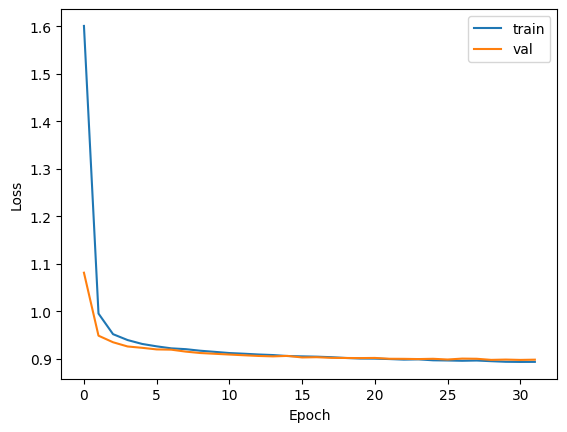

In [19]:
# visualizamos la curva de aprendizaje para valorar el progreso general del entrenamiento
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(H.history['loss'], label='train')
ax.plot(H.history['val_loss'], label='val')
ax.legend()
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
plt.show()

  Si bien ya sabemos que siempre hay margen de mejora, este parece sin duda un modelo bastante prometedor, pese a que aún no hemos evaluado sobre los datos de test.

## 4. Hito 2: Modelos 2D

Si bien podríamos diseñar nuestra propia red neuronal convolucional, ya sabemos que un diseño óptimo es un proceso costoso, largo, y sujeto a muchas condiciones. Por lo general preferiremos adoptar un modelo ya preentrenado, cuya arquitectura podamos además reutilizar. Sin embargo, nuestras imágenes son muy pequeñas, de `28x28` píxeles.

Visitando la tabla de modelos preentrenados en Imagenet, vamos a utilizar MobileNet debido a su pequeño tamaño, y por tanto su velocidad de inferencia. No obstante, esta red acepta inputs de tamaño `224x224`. Por tanto, redimensionaremos las imágenes.

In [20]:
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.layers import Resizing, GlobalAveragePooling2D

input_tensor = Input(shape=(28, 28, 3))
x = Resizing(224, 224)(input_tensor)
x = MobileNetV3Large(weights='imagenet', include_top=False)(x)
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', name='fc1')(x)
x = Dense(128, activation='relu', name='fc2')(x)
output_tensor = Dense(y_train_.shape[1], activation='softmax', name='cls_head')(x)
vision = Model(inputs=input_tensor, outputs=output_tensor)

vision.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/applications/mobilenet_v3.py:517: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 28, 28, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resizing (Resizing)                  │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MobileNetV3Large (Functional)        │ (None, 7, 7, 960)           │       2,996,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 960)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 512)                 │         492,032 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc2 (Dense)                          │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cls_head (Dense)                     │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,554,951 (13.56 MB)

 Trainable params: 3,530,551 (13.47 MB)

 Non-trainable params: 24,400 (95.31 KB)

In [21]:
im_train = im_train.reshape(-1, 28, 28, 3)
im_val = im_val.reshape(-1, 28, 28, 3)
im_test = im_test.reshape(-1, 28, 28, 3)

Congelamos el modelo principal, nos interesa entrenar únicamente la parte de clasificación final:

In [22]:
for layer in vision.layers:
  if layer.name not in ['fc1', 'fc2', 'cls_head']:
    layer.trainable = False
vision.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 28, 28, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resizing (Resizing)                  │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MobileNetV3Large (Functional)        │ (None, 7, 7, 960)           │       2,996,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 960)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 512)                 │         492,032 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc2 (Dense)                          │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cls_head (Dense)                     │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,554,951 (13.56 MB)

 Trainable params: 558,599 (2.13 MB)

 Non-trainable params: 2,996,352 (11.43 MB)

In [23]:
# compilamos
vision.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# definimos el early-stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, min_delta=0.005)

# entrenamos
im_train.shape
H = vision.fit(im_train, y_train_, validation_data=(im_val, y_val_), epochs=200, callbacks=[early_stopping])

Epoch 1/200
154/154 ━━━━━━━━━━━━━━━━━━━━ 33s 129ms/step - accuracy: 0.6491 - loss: 1.1656 - val_accuracy: 0.6752 - val_loss: 1.0444
Epoch 2/200
154/154 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.6787 - loss: 1.0254 - val_accuracy: 0.6709 - val_loss: 1.0145
Epoch 3/200
154/154 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.6734 - loss: 0.9878 - val_accuracy: 0.6790 - val_loss: 0.9793
Epoch 4/200
154/154 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.6748 - loss: 1.0139 - val_accuracy: 0.6795 - val_loss: 0.9733
Epoch 5/200
154/154 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.6756 - loss: 0.9776 - val_accuracy: 0.6809 - val_loss: 0.9728
Epoch 6/200
154/154 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.6766 - loss: 0.9698 - val_accuracy: 0.6781 - val_loss: 0.9478
Epoch 7/200
154/154 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.6915 - loss: 0.9397 - val_accuracy: 0.6847 - val_loss: 0.9422
Epoch 8/200
154/154 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.6788 - loss: 0.9509 

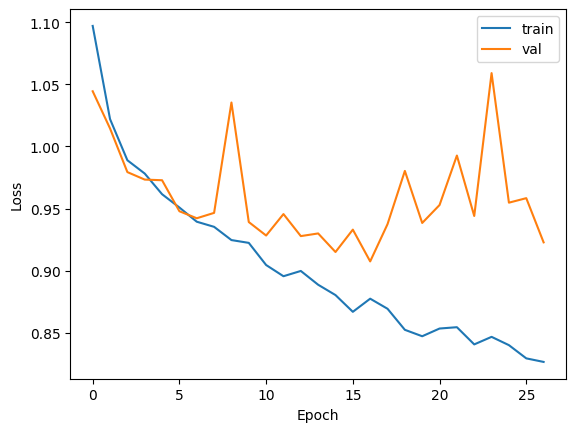

In [24]:
fig, ax = plt.subplots()
ax.plot(H.history['loss'], label='train')
ax.plot(H.history['val_loss'], label='val')
ax.legend()
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
plt.show()

## 5. Hito 3: late-fusion

Esto es, combinar las predicciones hechas, y aprender una nueva clasificación como si de nuevas features se trataran.


In [25]:
tab_preds_train = tab_model.predict(X_train.values)
tab_preds_val = tab_model.predict(X_val.values)
tab_preds_test = tab_model.predict(X_test.values)

im_preds_train = vision.predict(im_train)
im_preds_val = vision.predict(im_val)
im_preds_test = vision.predict(im_test)

154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 12s 52ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step


In [26]:
late_fusion_train = numpy.concatenate([tab_preds_train, im_preds_train], axis=1)
late_fusion_val = numpy.concatenate([tab_preds_val, im_preds_val], axis=1)

late_fusion_train.shape

(4907, 14)

In [27]:
from sklearn.svm import SVC

clf = SVC(kernel='rbf', probability=True)
clf.fit(late_fusion_train, y_train)

SVC(probability=True)

Hemos optado por un clasificador de ML porque las características de entrada son pocas (2), reduciendo de facto la cantidad de información extraíble desde un punto de vista de un enfoque Deep Learning. En estos casos, se puede pensar en las predicciones hechas por los modelos como un set de características con un significado muy concreto, conocido por nosotros. En este caso, representan de una manera muy clara la probabilidad de cada clase predicha para una misma muestra por cada uno de los modelos. Al no ser muy distinto de un escenario ML tradicional, hemos optado por ello.

No obstante, es importante resaltar que podríamos construir un sistema donde la clasificación final consistiera en una ( arias) capa `Dense` de manera equivalente.

## 6. Hito 4: Early-fusion

En este punto extraeremos los embeddings extraídos tras las capas convolucionales en el caso de las imágenes, mientras que tomaremos la representación de 32 características de la primera capa fully-connected del modelo tabular.

In [28]:
from tensorflow.keras.layers import Concatenate

# Create intermediate models
tabular_intermediate = Model(inputs=tab_model.input, outputs=tab_model.get_layer(index=1).output)
vision_intermediate = Model(inputs=vision.input, outputs=vision.get_layer('global_average_pooling2d').output)

# Define inputs
tabular_input = Input(shape=(X_train.shape[1],), name="tabular_input")
vision_input = Input(shape=(28, 28, 3), name="vision_input")

# Get intermediate features
tabular_features = tabular_intermediate(tabular_input)
vision_features = vision_intermediate(vision_input)

# Concatenate features
merged = Concatenate()([tabular_features, vision_features])

# Add classifier
x = Dense(128, activation="relu")(merged)
x = Dense(64, activation="relu")(x)
output = Dense(y_train_.shape[1], activation="softmax", name="final_output")(x)

# Create early fusion model
early_fusion_model = Model(inputs=[tabular_input, vision_input], outputs=output)
early_fusion_model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ tabular_input             │ (None, 17)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vision_input (InputLayer) │ (None, 28, 28, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_2 (Functional) │ (None, 32)             │            576 │ tabular_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_3 (Functional) │ (None, 960)            │      2,996,352 │ vision_input[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 992)            │              0 │ functional_2[0][0],    │
│                           │                        │                │ functional_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 128)            │        127,104 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 64)             │          8,256 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ final_output (Dense)      │ (None, 7)              │            455 │ dense_4[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 3,132,743 (11.95 MB)

 Trainable params: 136,391 (532.78 KB)

 Non-trainable params: 2,996,352 (11.43 MB)

In [29]:
# Preparamos el input data
train_inputs = {
    "tabular_input": X_train,
    "vision_input": im_train
}

val_inputs = {
    "tabular_input": X_val,
    "vision_input": im_val
}

early_fusion_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, min_delta=0.005)
H = early_fusion_model.fit(train_inputs, y_train_, validation_data=(val_inputs, y_val_), epochs=100, callbacks=[early_stopping])


Epoch 1/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 29s 121ms/step - accuracy: 0.6295 - loss: 1.1975 - val_accuracy: 0.7071 - val_loss: 0.8962
Epoch 2/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - accuracy: 0.7072 - loss: 0.8991 - val_accuracy: 0.7076 - val_loss: 0.8930
Epoch 3/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.7129 - loss: 0.8769 - val_accuracy: 0.7118 - val_loss: 0.8821
Epoch 4/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.7252 - loss: 0.8285 - val_accuracy: 0.7128 - val_loss: 0.8647
Epoch 5/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.7149 - loss: 0.8534 - val_accuracy: 0.7161 - val_loss: 0.8576
Epoch 6/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.7295 - loss: 0.8210 - val_accuracy: 0.7152 - val_loss: 0.8586
Epoch 7/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.7306 - loss: 0.8251 - val_accuracy: 0.7137 - val_loss: 0.8424
Epoch 8/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.7192 - loss: 0.8318

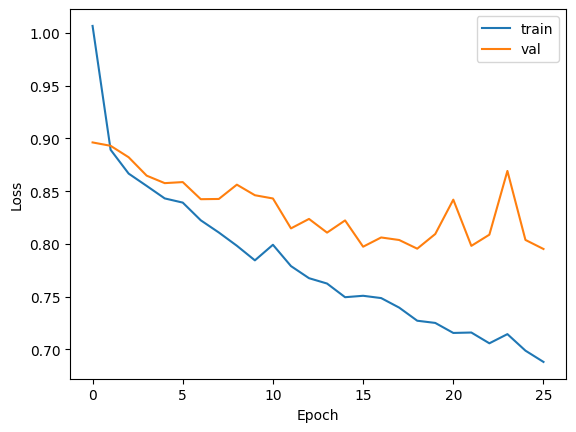

In [30]:
fig, ax = plt.subplots()
ax.plot(H.history['loss'], label='train')
ax.plot(H.history['val_loss'], label='val')
ax.legend()
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
plt.show()

## 7. Resultados

En los apartados anteriores, si bien son correctos, y en gran medida parecen resultados satisfactorios visto el desempeño a simple vista, podríamos emplear tiempo y esfuerzo adicional en desarrollar la configuración idónea de hiperparámetros.

Asumimos no obstante que en este punto estamos satisfechos con la configuración de los mismos, procediendo a obtener resultados sobre los datos de test.

### 7.0. ZeroR (baseline)


In [31]:
counts = y_test.value_counts()
counts.index = [tab_col_translation['label'][i] for i in counts.index]
print(counts)

nv       2012
mel       334
bkl       330
bcc       154
akiec      98
vasc       43
df         34
Name: count, dtype: int64


Así que el **zeroR, nuestro baseline, es 2012 / 3005 = 0.67 (67%)**

### 7.1. Datos tabulares


In [32]:
from sklearn.metrics import classification_report

tab_preds = tab_model.predict(X_test.values)
gt_test = numpy.argmax(y_test_, axis=1)
cr = classification_report(gt_test, numpy.argmax(tab_preds, axis=1), target_names=tab_col_translation['label'])
print(cr)

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
              precision    recall  f1-score   support

         bkl       0.38      0.50      0.43       330
          nv       0.77      0.95      0.85      2012
          df       0.00      0.00      0.00        34
         mel       0.23      0.06      0.10       334
        vasc       0.00      0.00      0.00        43
         bcc       0.00      0.00      0.00       154
       akiec       0.00      0.00      0.00        98

    accuracy                           0.70      3005
   macro avg       0.20      0.22      0.20      3005
weighted avg       0.58      0.70      0.63      3005



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### 7.2. Imágenes

In [33]:
vis_preds = vision.predict(im_test)
cr = classification_report(gt_test, numpy.argmax(tab_preds, axis=1), target_names=tab_col_translation['label'])
print(cr)

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
              precision    recall  f1-score   support

         bkl       0.38      0.50      0.43       330
          nv       0.77      0.95      0.85      2012
          df       0.00      0.00      0.00        34
         mel       0.23      0.06      0.10       334
        vasc       0.00      0.00      0.00        43
         bcc       0.00      0.00      0.00       154
       akiec       0.00      0.00      0.00        98

    accuracy                           0.70      3005
   macro avg       0.20      0.22      0.20      3005
weighted avg       0.58      0.70      0.63      3005



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### 7.3. Late-fusion

In [34]:
late_fusion_preds = clf.predict(numpy.concatenate([tab_preds_test, im_preds_test], axis=1))
cr = classification_report(gt_test, late_fusion_preds, target_names=tab_col_translation['label'])
print(cr)

              precision    recall  f1-score   support

         bkl       0.48      0.38      0.42       330
          nv       0.79      0.96      0.87      2012
          df       0.00      0.00      0.00        34
         mel       0.47      0.24      0.31       334
        vasc       0.00      0.00      0.00        43
         bcc       0.45      0.22      0.30       154
       akiec       0.41      0.17      0.24        98

    accuracy                           0.73      3005
   macro avg       0.37      0.28      0.31      3005
weighted avg       0.67      0.73      0.68      3005



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### 7.4. Early-fusion

In [35]:
test_inputs = {
    "tabular_input": X_test,
    "vision_input": im_test
}

early_fusion_preds = early_fusion_model.predict(test_inputs)
cr = classification_report(gt_test, numpy.argmax(early_fusion_preds, axis=1), target_names=tab_col_translation['label'])
print(cr)

94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step
              precision    recall  f1-score   support

         bkl       0.47      0.36      0.41       330
          nv       0.81      0.94      0.87      2012
          df       0.00      0.00      0.00        34
         mel       0.45      0.30      0.36       334
        vasc       0.00      0.00      0.00        43
         bcc       0.57      0.22      0.32       154
       akiec       0.31      0.39      0.34        98

    accuracy                           0.73      3005
   macro avg       0.37      0.32      0.33      3005
weighted avg       0.68      0.73      0.70      3005



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### 7.5. Estudio por método de diagnóstico

In [131]:
print(f"Classes correspond to: {list(tab_col_translation['label'])}")
dx_methods = dx_type[X_test.index].unique()
for method in dx_methods:
  is_method = (dx_type[X_test.index] == method).values
  method_labels = y_test[is_method]
  method_predictions = numpy.argmax(tab_preds[is_method], axis=1)
  print(f"Method: {method}")
  cr = classification_report(method_labels, method_predictions)
  print(cr)


Classes correspond to: ['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec']
Method: follow_up
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.97      0.99      1142
           3       0.00      0.00      0.00         0

    accuracy                           0.97      1142
   macro avg       0.33      0.32      0.33      1142
weighted avg       1.00      0.97      0.99      1142

Method: histo
              precision    recall  f1-score   support

           0       0.30      0.47      0.37       216
           1       0.57      0.91      0.70       719
           2       0.00      0.00      0.00        18
           3       0.28      0.06      0.10       334
           4       0.00      0.00      0.00        21
           5       0.00      0.00      0.00       154
           6       0.00      0.00      0.00        98

    accuracy                           0.50      1560
   macro avg       0.16  

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.p

### 7.6. Estudio por sexo

In [46]:
sex = tab_data["sex"][X_test.index].unique()
sex_str = ["male", "female", 'unknown']
for s in sex:
  is_sex = (tab_data["sex"][X_test.index] == s).values
  sex_labels = y_test[is_sex]
  sex_predictions = numpy.argmax(tab_preds[is_sex], axis=1)
  print(f"Sex: {sex_str[s]}")
  cr = classification_report(sex_labels, sex_predictions)
  print(cr)

Sex: female
              precision    recall  f1-score   support

           0       0.40      0.59      0.48       142
           1       0.81      0.95      0.88       992
           2       0.00      0.00      0.00        18
           3       0.16      0.02      0.04       135
           4       0.00      0.00      0.00        22
           5       0.00      0.00      0.00        52
           6       0.00      0.00      0.00        29

    accuracy                           0.74      1390
   macro avg       0.20      0.22      0.20      1390
weighted avg       0.64      0.74      0.68      1390

Sex: male
              precision    recall  f1-score   support

           0       0.36      0.43      0.39       188
           1       0.73      0.95      0.82      1005
           2       0.00      0.00      0.00        16
           3       0.25      0.09      0.13       199
           4       0.00      0.00      0.00        21
           5       0.00      0.00      0.00       102
  

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

### 7.8. Interpretación modelo tabular (SHAP)

/usr/local/lib/python3.11/dist-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(3005, 17))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(6010, 17))']
  warnings.warn(msg)


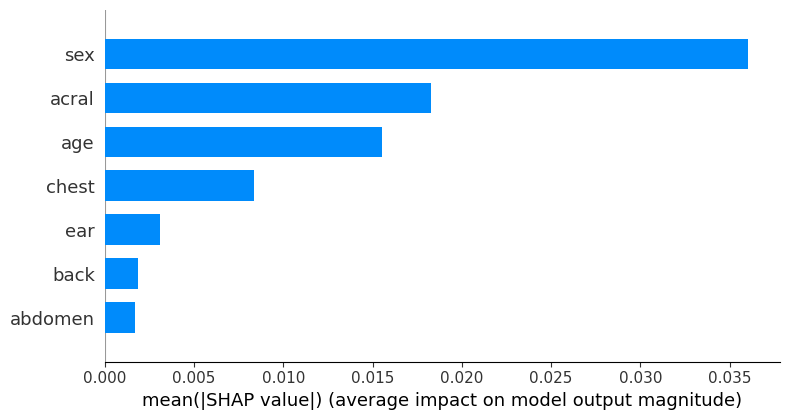

In [38]:
import shap

dx_names = list(tab_col_translation["label"])
explainer = shap.DeepExplainer(tab_model, X_test.to_numpy())
shap_values = explainer.shap_values(X_test.to_numpy())
i = 1
shap_values_class_i = shap_values[i]
shap.summary_plot(shap_values_class_i, feature_names=X_test.columns, plot_type="bar")

### 7.9. ROC-AUC

Esta métrica, el *Receiver Operating Curve - Area Under the Curve*  es especialmente útil para valorar el funcionamiento de un clasificador binario, a nivel de la calidad de las probabilidades predichas.

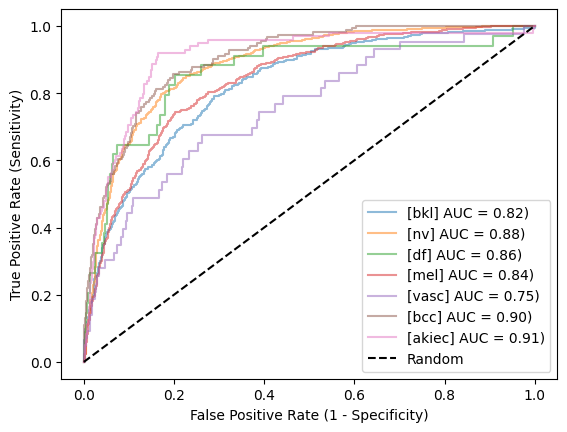

In [126]:
from sklearn.metrics import roc_auc_score, roc_curve

# Debe realizarse para clases por separado, ya que es una métrica diseñada para escenarios binarios.
def compute_and_plot_AUROC(y_true, y_probs, label_names):
  for i, label_name in enumerate(label_names):
    gt = (y_true == i).astype(numpy.int8)
    label_preds = y_probs[:, i]
    fpr, tpr, thresholds = roc_curve(gt, label_preds)
    roc_auc = roc_auc_score(gt, label_preds)
    plt.plot(fpr, tpr, label=f'[{label_name}] AUC = {roc_auc:.2f})', alpha=0.5)
  plt.plot([0, 1], [0, 1], 'k--', label='Random')  # La diagonal representa un clasifiador aleatorio
  plt.xlabel('False Positive Rate (1 - Specificity)')
  plt.ylabel('True Positive Rate (Sensitivity)')
  plt.legend(loc='lower right')
  plt.show()


compute_and_plot_AUROC(y_test, early_fusion_preds, tab_col_translation["label"])



## 8. Discusión

Como puede observar el alumno, lo presentado aquí no es sino una pequeña muestra de todo el trabajo que puede llegar a realizarse para resolver la práctica. Como se ha indicado a lo largo del curso, el énfasis se ha puesto más en entender el comportamiento del modelado con respecto a los datos que a la obtención de métricas con puntuaciones mayores.

Debe notarse que una de las principales cualidades de este problema es la desproporción entre las diferentes clases existente. Enfoques basados en *oversampling* (repetir muestras de clases minoritarias) o *undersampling* (limitar la propoción de muestras de la clase mayoritaria), si bien son prácticas comunes, carecen de base teórica y constituyen la manera más clara de introducir sesgos en nuestro modelo. Es cierto, las métricas aparentarán ser mejores, pero a costa de entrenar nuestros modelos en un escenario no realista. Por ello, nosotros reforzamos el uso de la estratificación en las particiones. En esta propuesta de solución no logramos superar en muchos casos esta desproporción, y apuestas futuras estarían centradas en comprender los fallos del modelo de cara a resolver con modelos adicionales/complementarios las clases minoritarias. No obstante, debe notarse la relativa simplicidad de los modelos empleados, en aras de un desarrollo rápido. Además, debe notarse que la rama visual apenas es entrenada en este dataset, habiendo congelado los pesos de la red usada como "backbone" (MobileNetV3), una red particularmente simple, pensada para su inclusión en dispositivos. Así, futuras mejoras incluirían descongelar los pesos de la rama visual (fine-tuning) y reemplazar MobileNetV3 por una red con mayor capacidad expresiva.

Nuestro baseline es de aproximadamente el 67%, o lo que es lo mismo, accuracy = 0.67 (CI = [0.65, 0.69]). Este **intervalo de confianza** es importante, pues nos indica si existe una mejora estadísticamente significativa, o la mejora de un modelo con respecto a este baseline se debe a motivos espúreos como el punto de inicio del modelo, o el orden de los datos. Este ratio es alto debido a que la clase mayoritaria, **nv**, está muy presente en los datos, frente a clases con apenas alguna decena de muestras.

Nuestros modelos unimodales (Hitos 1 & 2) son incapaces de mejorar nuestro baseline, ya que ambos modelos alcanzan accuracy = 0.70 (0.68, 0.72). Al solapar el margen inferior con el del baseline, no podemos afirmar de manera tajante que ninguno de estos sistemas sea mejor que el baseline. Además, podemos comprobar cómo en ambos modelos algunas categorías no son predichas nunca.

Los modelos multimodales parecen complementarse ligeramente, pues sí encontramos que algunas clases que por separado no se predecían nunca, ahora sí aparecen predichas. No se resuelve del todo el problema, y se deja como trabajo futuro el continuar mejorando la **cobertura** de los modelos. No existe una diferencia significativa entre ambos modelos multimodales (accuracy = 0.73 (0.71, 0.75)), ni entre estos y los modelos unimodales. Sin embargo, **sí existe una diferencia estadísticamente significativa entre los modelos multimodales y el baseline**, confirmando por tanto el aprendizaje de los modelos y su complementariedad.

De cara a continuar el trabajo, presentamos una serie de observaciones acerca del actual estado de funcionamiento de los modelos presentados:

- El modelo tabular parece funcionar de manera muy dispareja dependiendo del tipo de diagnóstico que haya tenido lugar, lo cual a su vez limita de manera severa las etiquetas vistas. Por tanto, un enfoque basado en **Mezcla de Expertos** podría llegar a ayudar, combinando modelos especializados en diferentes tipos de diagnóstico en lugar de incluir esto como característica. Sería interesante comprender mejor la relación entre esta información y atributos de las imágenes.
- El modelo tabular parece funcionar significativamente mejor en mujeres que en varones, pese a estar menos representadas en el dataset. Debe profundizarse en comprender si existen correlaciones entre ciertas enfermedades y el sexo (estudio univariables) para comprender mejor las relaciones existentes entre variables.
- En efecto, según puede verse en el análisis por valores SHAP (técnica común de interpretabilidad), el sexo parece ser la característica más importante a la hora de predecir la clase mayoritaria, **nv**, seguida de una localización corporal concreta, y completando el podio de importancias con la edad. Esto refuerza el punto anterior acerca de la necesidad de comprender la relación entre ciertas enfermedades y el sexo.
- El análsis del AUC de uno de los modelos de fusión muestra resultados satisfactorios en la medida en que para todas las enfermedades logramos mejorar de manera significativa el funcionamiento tanto del baseline como de predicciones aleatorias (marcada como la línea diagonal). Sin embargo, podemos apreciar como `vasc` se diagnostica de manera visible peor que el resto de clases. Eso indica un fuerte sesgo de nuestros modelos, que inevitablemente llevaría a una peor cobertura de nuestro modelo en ese segmento poblacional al poner nuestros modelos en producción.

Es importante recalcar que las opciones de mejora son muchas y muy variadas, pero algunas de estas limitaciones se mantendrán por mucho que trabajemos en nuestros modelos, dada la naturaleza intrínsecamente estadística e iterativa del aprendizaje. Es por ello que es más importante el análisis posterior, comprendiendo las limitaciones de nuestros modelos, que las métricas. Siguientes iteraciones de nuestra propuestas pueden construirse, a la vista de nuestros análsisis, con algo más en mente que simplemente "mejorar las métricas". De nuevo, el mundo real es mucho más que un alto accuracy. Este es mi consejo final para vosotros:

**El bias, o sesgo, de los algoritmos, es una expresión manida para referirse a estos efectos. En ocasiones se pueden mitigar, pero la naturaleza de esta tecnología hace inevitable que existan diferencias. Lo importante es comprender en la medida de lo posible cuáles, y por qué se generan, y trabajar en esa línea. El trabajo no termina al entrenar y evaluar el modelo. Es en ese momento que comienza nuestra labor.**

Muchas gracias por vuesta atención y dedicación.